# Dados

In [1]:
import os
from pathlib import Path
import pandas as pd
import numpy as np
import cv2
import shutil
from module import data_read, setup
from torch.utils.data import ConcatDataset
from module.LightningModule import ClassificationModule
from module.setup import *
from module.data_read import *
from module.plot import imshow
from module import data_read

torch.manual_seed(random_state)

DDR_DIR = Path.cwd() / 'DDR-dataset/DR_grading'
IDRID_DIR = Path.cwd() / 'IDRID-Classificacao'
#FGADR_DIR = Path.cwd() / 'FGADR Dataset/Seg-set'

# Lighting Module

## Binary

In [2]:
# Leitura IDRID
train_idrid_dataset = IDRIDDataset(IDRID_DIR/'1. Original Images/a. Training Set',
                                   IDRID_DIR/'2. Groundtruths/a. IDRiD_Disease Grading_Training Labels.csv',
                                   data_transforms['test'],
                                   convert_to_binary=True)
test_idrid_dataset = IDRIDDataset(IDRID_DIR/'1. Original Images/b. Testing Set',
                                  IDRID_DIR/'2. Groundtruths/b. IDRiD_Disease Grading_Testing Labels.csv',                   
                                  data_transforms['test'],
                                  convert_to_binary=True)
idrid_dataset = ConcatDataset([train_idrid_dataset, test_idrid_dataset])

#### VGG16 instanciation

In [3]:
from torchvision import models
from torch import nn

# Transfer learning (fine tuning):
# Instanciação VGG16_BN
weights = models.VGG16_BN_Weights.DEFAULT # melhores pesos até o momento
vgg16 = models.vgg16_bn(weights=weights)
# transformações específicas da rede
vgg16_preprocess = weights.transforms()
# modificando a camada de classificação
num_ftrs = vgg16.classifier[-1].in_features
vgg16.classifier[-1] = nn.Linear(num_ftrs, num_classes)

In [4]:
vgg16_preprocess

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [5]:
vgg16.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=2, bias=True)
)

#### Execution

FOLD 0
--------------------------------


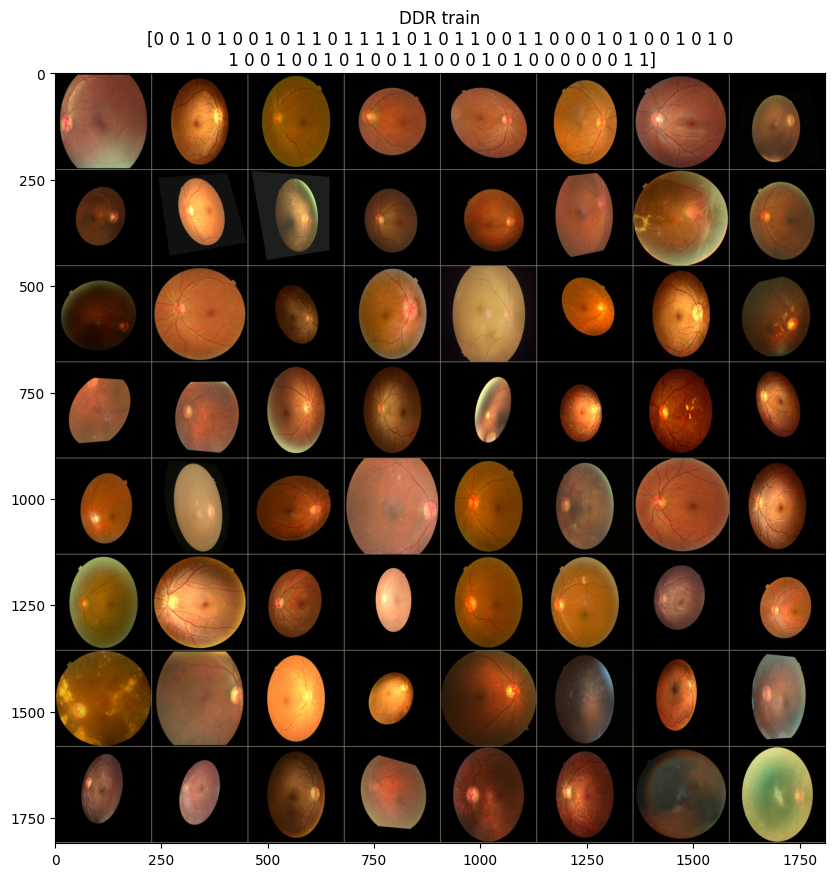

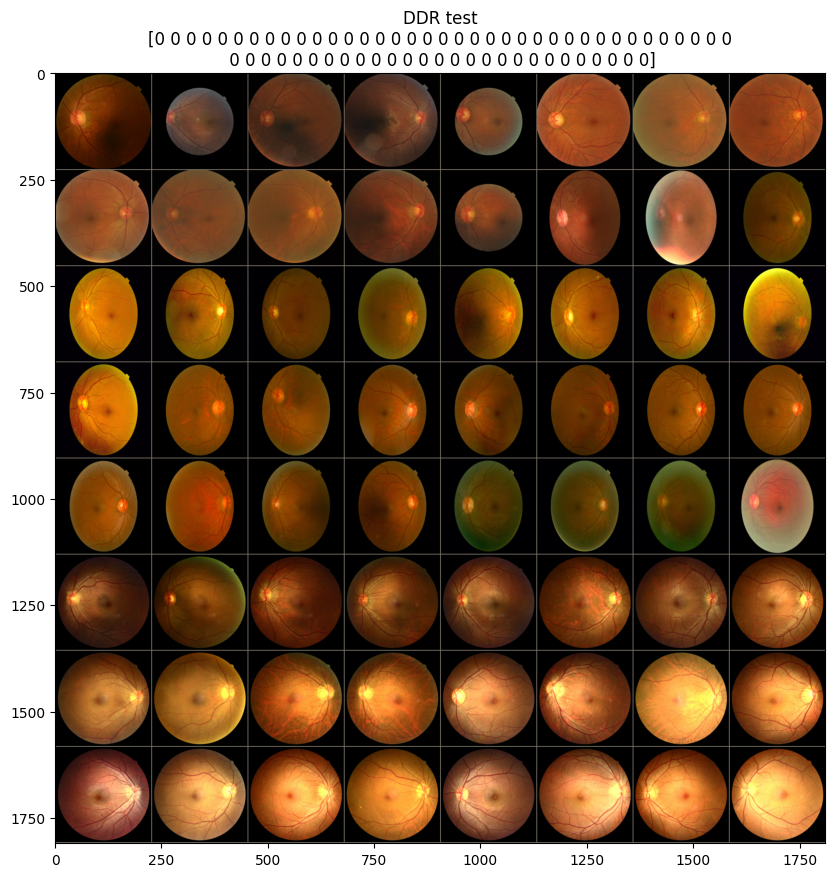

FOLD 1
--------------------------------


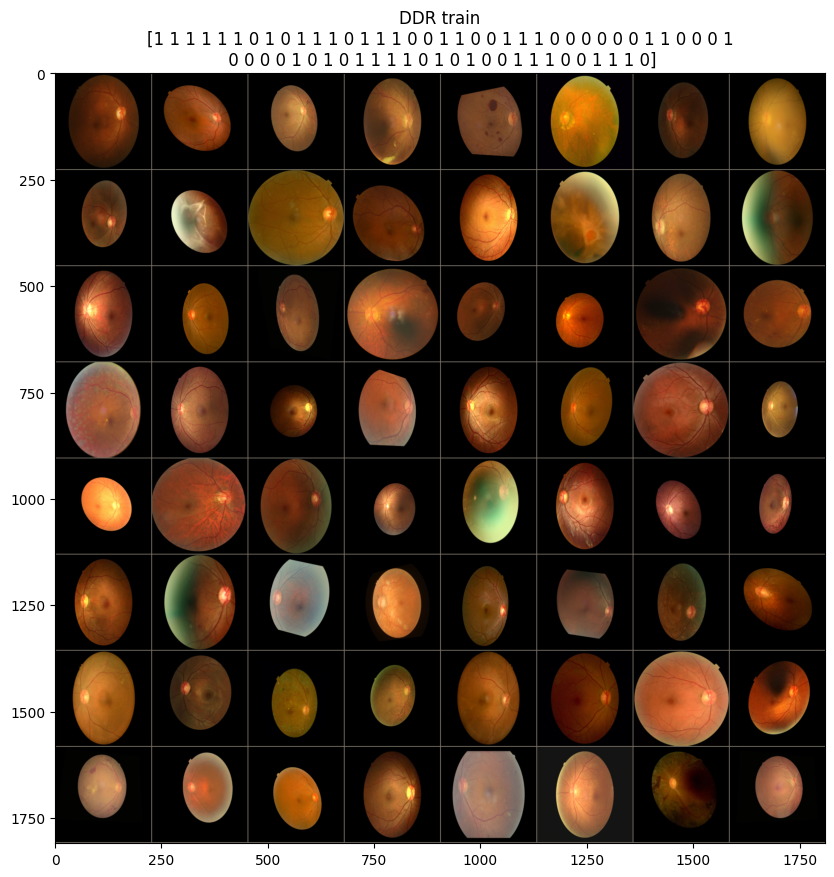

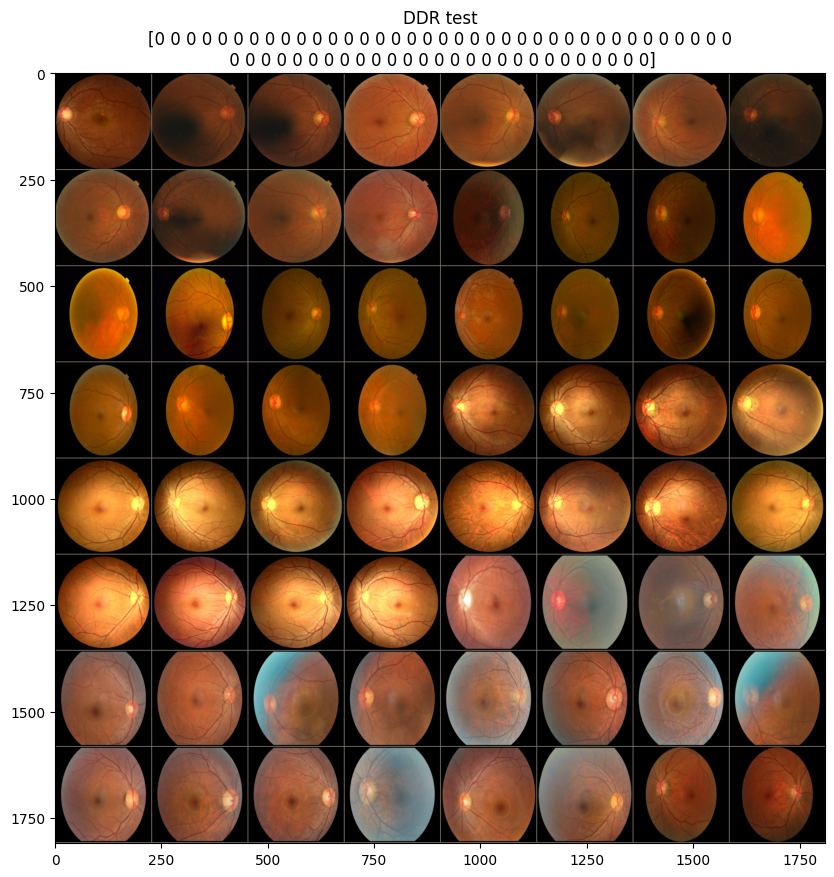

FOLD 2
--------------------------------


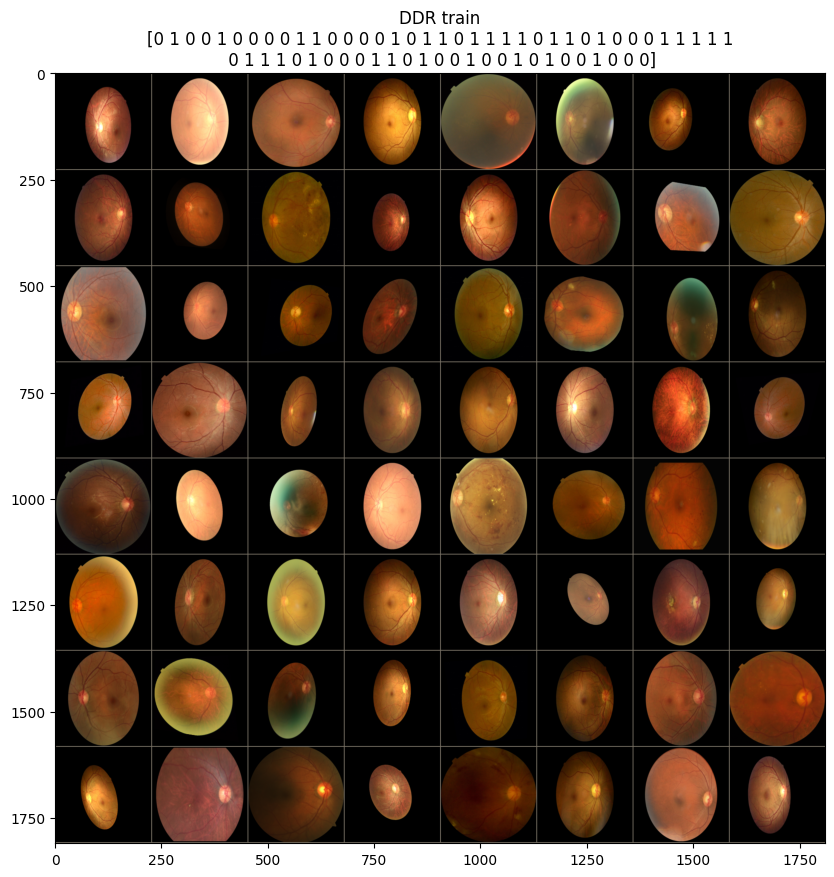

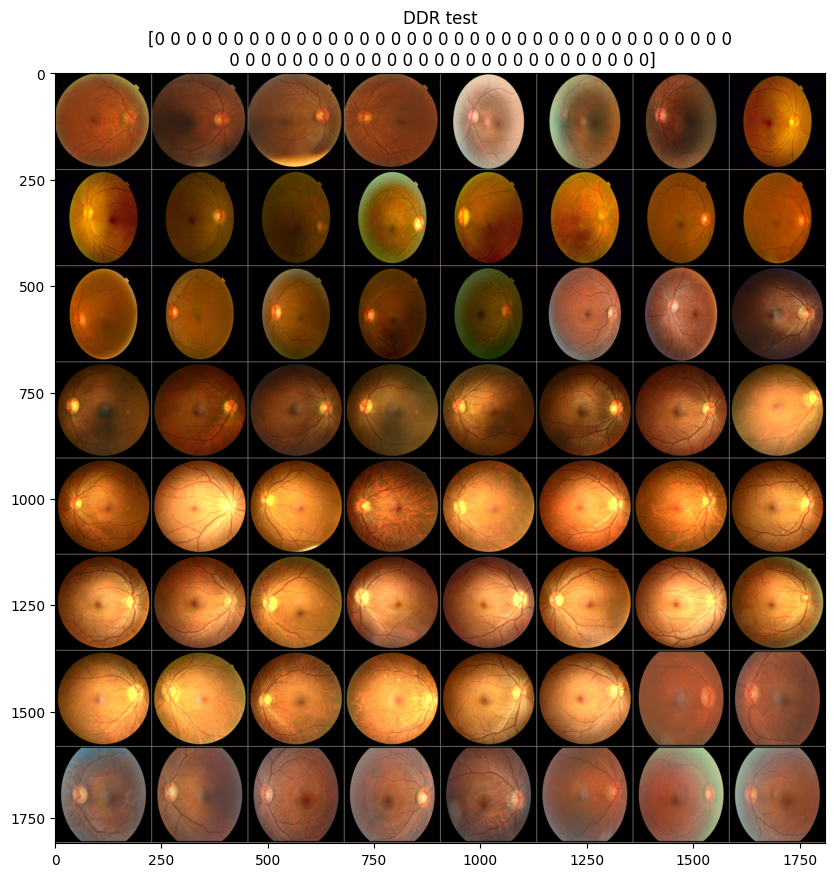

FOLD 3
--------------------------------


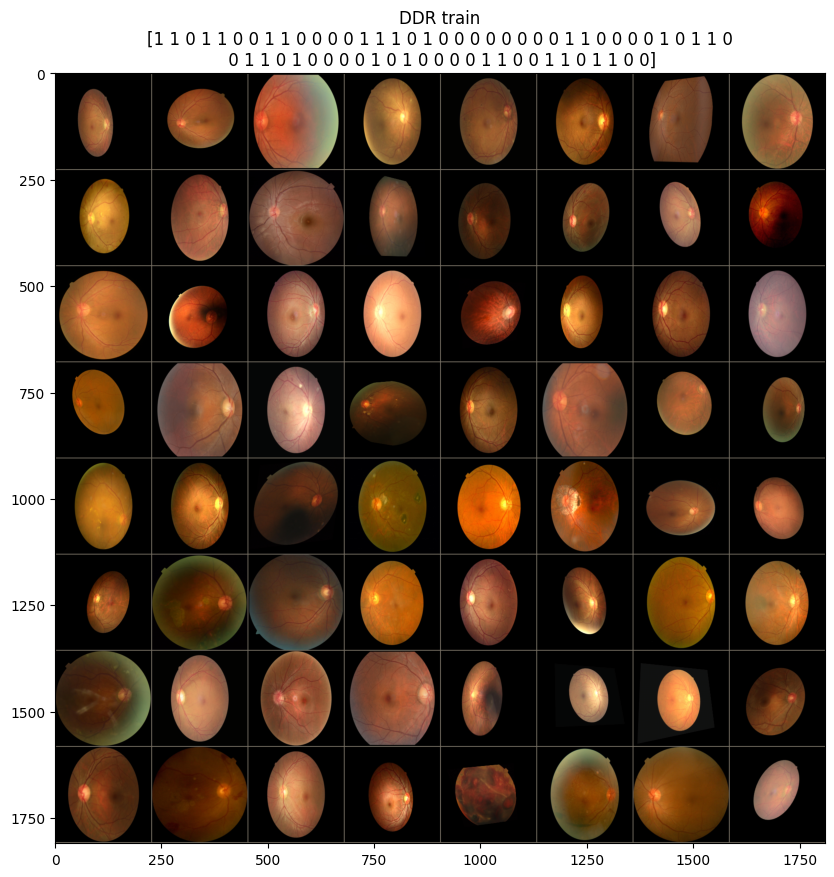

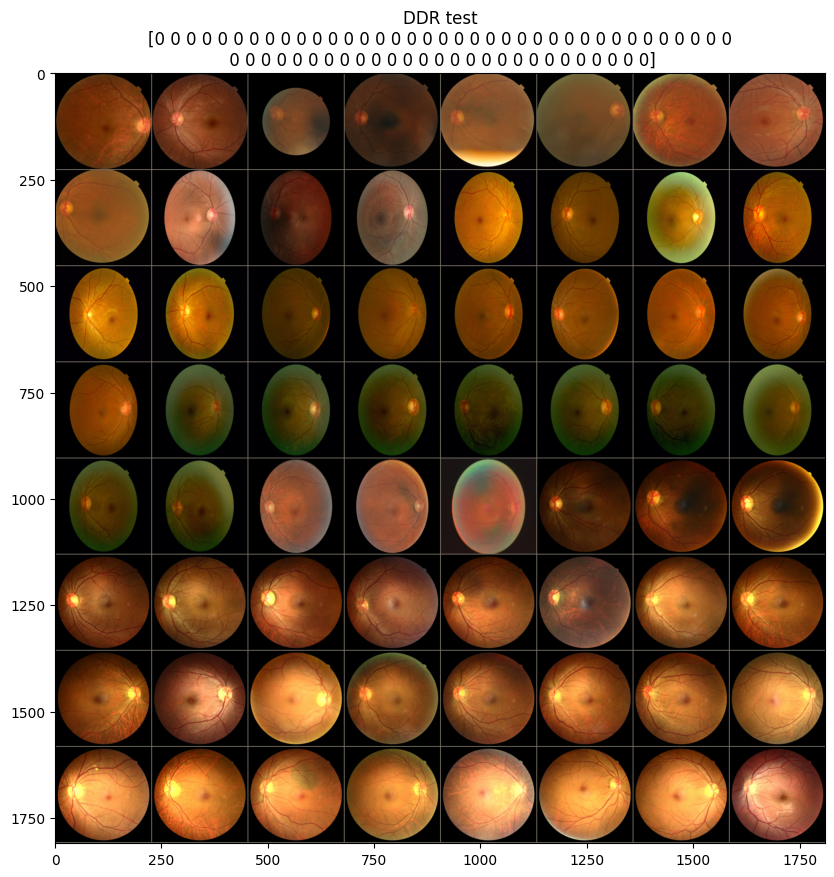

FOLD 4
--------------------------------


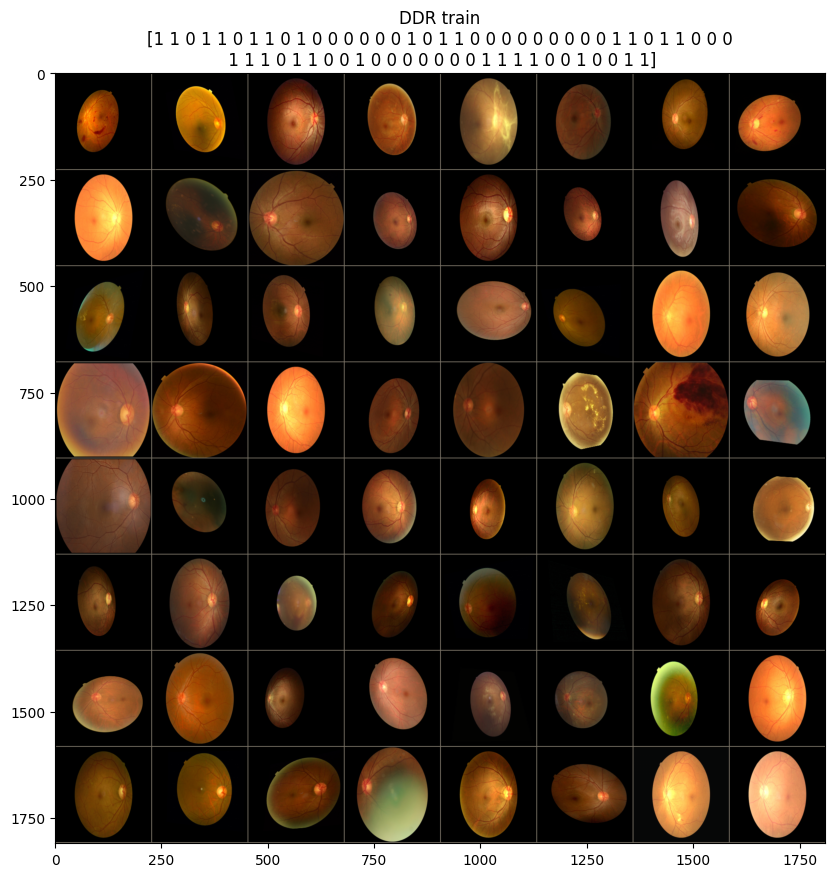

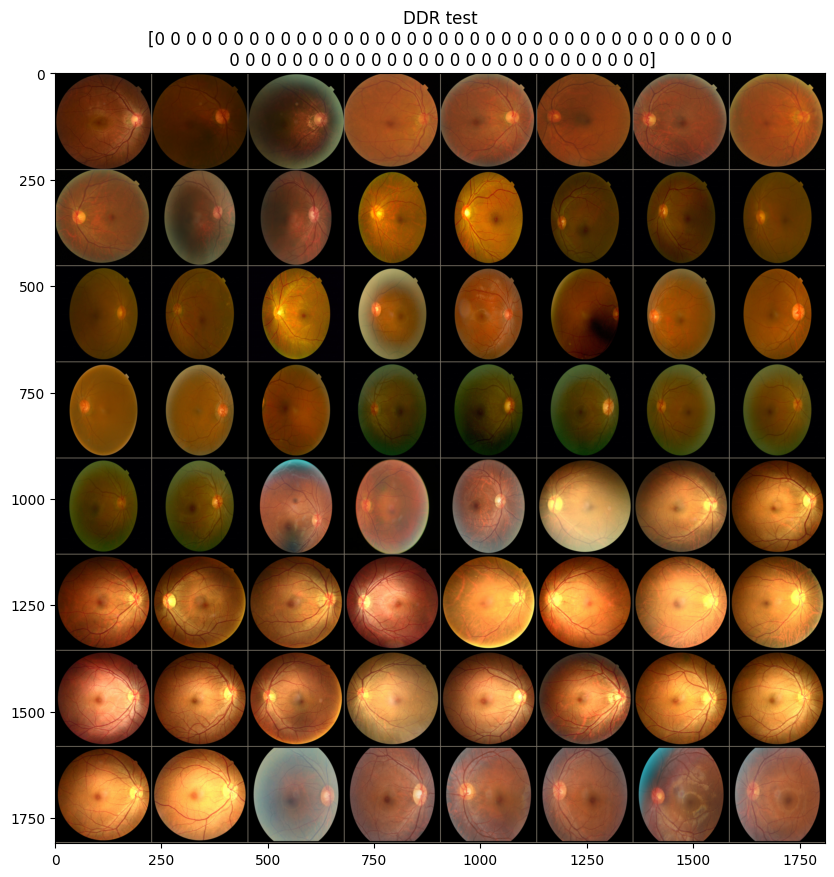

In [6]:
from lightning.pytorch.loggers import TensorBoardLogger
from sklearn.model_selection import KFold


anno_train_ddr = pd.read_csv(DDR_DIR/'train.txt', header=None, sep=' ')
anno_train_ddr[0] = 'train/'+anno_train_ddr[0]
anno_valid_ddr = pd.read_csv(DDR_DIR/'valid.txt', header=None, sep=' ')
anno_valid_ddr[0] = 'valid/'+anno_valid_ddr[0]
anno_test_ddr = pd.read_csv(DDR_DIR/'test.txt', header=None, sep=' ')
anno_test_ddr[0] = 'test/'+anno_test_ddr[0]

# Todas as anotações do DDR
anno_ddr = pd.concat([anno_train_ddr, anno_valid_ddr, anno_test_ddr], ignore_index=True)
kfold = KFold(n_splits=k_folds, shuffle=True, random_state=random_state)

for fold, (train_ids, test_ids) in enumerate(kfold.split(anno_ddr)):
    print(f'FOLD {fold}')
    print('--------------------------------')
    
    # Divide os dados com base nos atuais indices do K-fold
    train_dataset = DDRDatasetKFold(DDR_DIR, anno_ddr.iloc[train_ids], data_transforms['train'], convert_to_binary=True)
    test_dataset = DDRDatasetKFold(DDR_DIR, anno_ddr.iloc[test_ids], data_transforms['test'], convert_to_binary=True)


    # Definição dos dataloaders
    trainloader = torch.utils.data.DataLoader(
                      train_dataset,
                      batch_size=batch_size,
                      shuffle=True,
                      num_workers=20)
    testloader = torch.utils.data.DataLoader(
                      test_dataset,
                      batch_size=batch_size,
                      shuffle=False,
                      num_workers=20)
    idridloader = torch.utils.data.DataLoader(
                      idrid_dataset,
                      batch_size=batch_size,
                      num_workers=20)



    # # DEBUG:
    # plot DDR
    batch_train = next(iter(trainloader))
    imgs_train, labels_train = batch_train['img'], batch_train['retinopathy_grade']
    out_test = torchvision.utils.make_grid(imgs_train)
    imshow(out_test, title='DDR train\n'+str(labels_train.numpy()))
    
    batch_test = next(iter(testloader))
    imgs_test, labels_test = batch_test['img'], batch_test['retinopathy_grade']
    out_test = torchvision.utils.make_grid(imgs_test)
    imshow(out_test, title='DDR test\n'+str(labels_test.numpy()))
    
    # trainer = L.Trainer(fast_dev_run=4) # a execução do trainer se limitará a 2 batches
    # trainer = L.Trainer(limit_train_batches=30, max_epochs=1) # usar apenas 30% dos dados de cada lote de treino
    # trainer = L.Trainer(default_root_dir='checkpoints kfold/', accelerator='gpu', max_epochs=num_epochs)


    
    # # treino
    # vgg16_model = ClassificationModule(vgg16, loss_function, optim.Adam)
    # trainer.fit(model=vgg16_model, train_dataloaders=trainloader)
    # # teste
    # print(f'\n\n TEST FOLD {fold}\n\n')    
    # trainer.test(model=vgg16_model, dataloaders=testloader) # test na fold de test 
    # print('\n\n TESTE IDRID \n\n')    
    # trainer.test(model=vgg16_model, dataloaders=idridloader) # test no idrid
    